## FAIRNESS BY REGULARIZATION

Here we will see how we can use the popular variance reduction technique in machine learning model to get a fair trained classifier. We will be using the [Adult Dataset](https://archive.ics.uci.edu/ml/datasets/adult) for our demonstration purpose.

### IMPORTNG THE NECESSARY LIBRARIES

We will be using the open-source [AIF360](https://github.com/Trusted-AI/AIF360) package to use several fairness based metrics.

In [25]:
import numpy as np
np.set_printoptions(suppress = True)
import pandas as pd

import matplotlib.pyplot as plt

# Importing the Dataset
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.metrics.utils import compute_boolean_conditioning_vector
from common_utils import compute_metrics

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

import pickle

### DATASET

In [2]:
priv_group = [{'sex':1}]
unpriv_group = [{'sex':0}]

In [3]:
data_adult = load_preproc_data_adult(['sex'])

### FAIRNESS BASED REGULARIZED CLASSIFIER

Here we will fit a regularized logistic regression classifier using different regularization terms for each trained model, to compare the results in terms of accuracy and fairness levels achieved by the model.

#### - EQUALISED ODDS REGULARIZATION

- **METHOD**

Here we will try to achieve a classifier with equalized odds using a regularization term in the loss function which has difference in the values of FPR and FNR for both the classes as shown below:

$$Loss(\theta;G,X)\ =\ -ll(\theta;G,X) + C_1|FPR(G=f)-FPR(G=m)|\\ + C_2|FNR(G=f)-FNR(G=m)| + \frac{1}{2}C_3||\theta||_2^2$$
where, 
$$ll(\theta;G,X) = \sum_{i=1}^n y_i\log(S(x_i^T.\theta))+(1-y_i)\log(1-S(x_i^T.\theta))\\ S(x) = \frac{1}{1+e^{-x}}$$
and $\theta$ represents the weights and biases of the model and $G,X$ is the given data.

We want to find the optimal value of $\theta^*$ such that,
$\DeclareMathOperator*{\argmin}{arg\,min}$
$$\theta^* = \argmin_\theta Loss(\theta;G,X)$$

To solve this above optimization problem, we use gradient descent, starting with an initial value of $\theta_0$, we update the weights and biases as follows,
$$\theta^{n+1} = \theta^{n} - lr\cdot \frac{\partial Loss(\theta;G,X)}{\partial \theta}$$
where, $lr$ is the learning rate.

We will use the common variant of the gradient descent, Stochastic Gradient Descent.

- **DISCUSSION**

We use this method as here the parameter updation happen along that direction which minimizes the Loss and since now our loss function has the fairness based reglarization terms added i.e. the FNR difference and FPR difference, our parameters updates will be such that they minimize these terms. Higher the value of $C_1$ and $C_2$, our model will follow the fairness norms more strictly, but it will cost the overall accuracy. Hence, we need to decide on the accuracy-fairness tradeoff depending on the domain of application of the trained Model.

- **IMPLEMENTATION**

To train our model, we will split our data into 2 parts i.e. training data and a test data

In [4]:
dset_raw_trn, dset_raw_tst = data_adult.split([0.7], shuffle=True)

In [5]:
dset_trn_pred = dset_raw_trn.copy(deepcopy=True)

Taking a look at the fairness metrics for the test data and the proportion of protected group and labels, we get:

In [6]:
def plot_prop_prtced_grp_lab(data, title="", figsize=(10,8)):
    feature_idx = np.where(np.array(data.feature_names) == data.protected_attribute_names[0])[0][0]
    n_p_fav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.privileged_protected_attributes[0],data.labels == data.favorable_label) == True)[0])
    n_unp_fav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.unprivileged_protected_attributes[0],data.labels == data.favorable_label) == True)[0])
    n_p_unfav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.privileged_protected_attributes[0],data.labels == data.unfavorable_label) == True)[0])
    n_unp_unfav = len(np.where(np.logical_and(data.features[:,feature_idx] == data.unprivileged_protected_attributes[0],data.labels == data.unfavorable_label) == True)[0])
    plt.figure(figsize=figsize)
    xlocs = [i for i in range(4)]
    y = [n_p_fav/(n_p_fav+n_p_unfav), n_unp_fav/(n_unp_fav+n_unp_unfav), n_p_unfav/(n_p_fav+n_p_unfav), n_unp_unfav/(n_unp_fav+n_unp_unfav)]
    plt.bar(['priv grp,fav label','unpriv grp,fav label', 'priv grp,unfav label', 'unpriv grp,unfav label'], y)
    for i, v in enumerate(y):
        plt.text(xlocs[i] - 0.05, v + 0.01, str(round(v,2)))
    plt.title(title)
    plt.show()

In [7]:
dset_raw_trn_metrics = BinaryLabelDatasetMetric(dset_raw_trn,
                                      unprivileged_groups=unpriv_group,
                                     privileged_groups=priv_group)
print("Statistical Parity Difference:",dset_raw_trn_metrics.statistical_parity_difference())
print("Disparate Impact:",dset_raw_trn_metrics.disparate_impact())
print("Consistency:",dset_raw_trn_metrics.consistency()[0])

Statistical Parity Difference: -0.19610642994400979
Disparate Impact: 0.3553324955904343
Consistency: 0.711193658779143


We see the training data is quite unfair. The statistical parity difference is significantly below 0 implying the data shows disfavor of the unprivileged group to the favorable outcome. Disparate Impact close to 0 also shows that.

- **FITTING MODELS**
    - No Fairness Regularized Classifier (Model: $M$)
    - Equalized Odd Regularized Classifier (Model: $M_F$)

Standardizing the training dataset

In [8]:
scaler = StandardScaler()
dset_trn = scaler.fit_transform(dset_raw_trn.features)
y_trn = dset_raw_trn.labels.ravel()
dset_trn = torch.from_numpy(dset_trn).float()
y_trn = torch.from_numpy(y_trn).float()
y_trn = y_trn.view(y_trn.shape[0], 1)

Logistic Regression Class as needed by PyTorch

In [9]:
class Log_Reg(nn.Module):
    def __init__(self, size_in):
        super().__init__()
        self.linear = nn.Linear(size_in, 1)
    def forward(self, x):
        prob_pred = torch.sigmoid(self.linear(x))
        return prob_pred

Below are the two models $M$ and $M_F$ as mentioned before

In [10]:
M = Log_Reg(len(dset_raw_trn.feature_names)) # Non-Fairness Based Regularized Model
M_F = Log_Reg(len(dset_raw_trn.feature_names)) # Fairness Based Regularization Model

In [11]:
num_epochs = 2000 # Number of Epochs
learning_rate = 0.01 # Learning Rate

# Stochastic Gradient Descent Optimizers
optimizer_M = torch.optim.SGD(M.parameters(), lr= learning_rate)
optimizer_M_F = torch.optim.SGD(M_F.parameters(), lr= learning_rate)

# Binary Cross Entropy Loss Functions
criterion = nn.BCELoss()
criterion_f = nn.BCELoss()

In [12]:
# Used Values in the FPR and FNR Score Diffs
trn_data_metric = BinaryLabelDatasetMetric(dset_raw_trn, 
                                           unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)
NA_pos = trn_data_metric.num_positives(True)
NA_neg = trn_data_metric.num_negatives(True)
NB_pos = trn_data_metric.num_positives(False)
NB_neg = trn_data_metric.num_negatives(False)

Defining the fairness based regularization functions

In [13]:
def fnr_score_diff(p_pred):
    FNR_A = torch.sum(p_pred[:,0][np.logical_and((dset_raw_trn.features[:,1] == 1),(dset_raw_trn.labels.ravel() == 1))])
    FNR_B = torch.sum(p_pred[:,0][np.logical_and((dset_raw_trn.features[:,1] == 0),(dset_raw_trn.labels.ravel() == 1))])
    return torch.abs(-FNR_A/NA_pos + FNR_B/NB_pos)

def fpr_score_diff(p_pred):
    FPR_A = torch.sum(p_pred[:,0][np.logical_and((dset_raw_trn.features[:,1] == 1),(dset_raw_trn.labels.ravel() == 0))])
    FPR_B = torch.sum(p_pred[:,0][np.logical_and((dset_raw_trn.features[:,1] == 0),(dset_raw_trn.labels.ravel() == 0))])
    return torch.abs(-FPR_A/NA_neg + FPR_B/NB_neg)

# Fairness Based Regularized Loss
def loss_f(p_pred, y, C1=1, C2=1):
    return criterion_f(p_pred, y_trn) + C1*fpr_score_diff(p_pred) + C2*fnr_score_diff(p_pred)

Training the non-fairness regularized Model $M$

In [15]:
# Training M
print("Training M:")
M.train()
for epoch in range(num_epochs):
    p_pred = M(dset_trn)
    loss= criterion(p_pred, y_trn)
    
    loss.backward()
    optimizer_M.step()
    
    optimizer_M.zero_grad()
    
    if (epoch+1) % 500== 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
        
print("Trained M's Performance on Training Data:")        
with torch.no_grad():
    dset_trn_pred.labels = (p_pred > 0.5).numpy().astype(float)
    
    mod_metrics = ClassificationMetric(dset_raw_trn, dset_trn_pred,
                                        unprivileged_groups=unpriv_group,
                                        privileged_groups=priv_group)
    print("Accuracy:", mod_metrics.accuracy())
    print("Predictive Parity Difference:", mod_metrics.positive_predictive_value(False)-mod_metrics.positive_predictive_value(True))
    print("FNR Difference:", mod_metrics.false_negative_rate_difference())
    print("FPR Difference:", mod_metrics.false_positive_rate_difference())
    print("Accuracy Difference:", mod_metrics.error_rate_difference())
    print("Statistical Parity Difference:",mod_metrics.statistical_parity_difference())
    print("Disparate Impact:",mod_metrics.disparate_impact())
    print("Consistency:",mod_metrics.consistency()[0])

Training M:
epoch: 500, loss = 0.4650
epoch: 1000, loss = 0.4373
epoch: 1500, loss = 0.4288
epoch: 2000, loss = 0.4252
Trained M's Performance on Training Data:
Accuracy: 0.8049372605223902
Predictive Parity Difference: -0.6577851790174855
FNR Difference: 0.45376220562894887
FPR Difference: -0.10320798543536945
Accuracy Difference: -0.12988531431914618
Statistical Parity Difference: -0.20984580439435635
Disparate Impact: 0.0
Consistency: 0.711193658779143


The above model without any fairness intervention performs very bad in terms of fairness. We have seen this before in the [Adult Dataset Model](Fairness-Definitions-Comparison.ipynb)

Training Fairness Regularized Model $M_F$

In [16]:
# Training M_F
print("Training M_F:")
M_F.train()
for epoch in range(num_epochs):
    p_pred = M_F(dset_trn)
    
    loss= loss_f(p_pred, y_trn)
    
    loss.backward()
    optimizer_M_F.step()
    
    optimizer_M_F.zero_grad()
    
    if (epoch+1) % 500== 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

print("Trained M_F's Performance on Training Data:")  
with torch.no_grad():
    dset_trn_pred.labels = (p_pred > 0.5).numpy().astype(float)
    
    mod_metrics = ClassificationMetric(dset_raw_trn, dset_trn_pred,
                                        unprivileged_groups=unpriv_group,
                                        privileged_groups=priv_group)
    print("Accuracy:", mod_metrics.accuracy())
    print("Predictive Parity Difference:", mod_metrics.positive_predictive_value(False)-mod_metrics.positive_predictive_value(True))
    print("FNR Difference:", mod_metrics.false_negative_rate_difference())
    print("FPR Difference:", mod_metrics.false_positive_rate_difference())
    print("Accuracy Difference:", mod_metrics.error_rate_difference())
    print("Statistical Parity Difference:",mod_metrics.statistical_parity_difference())
    print("Disparate Impact:",mod_metrics.disparate_impact())
    print("Consistency:",mod_metrics.consistency()[0])

Training M_F:
epoch: 500, loss = 0.4908
epoch: 1000, loss = 0.4573
epoch: 1500, loss = 0.4497
epoch: 2000, loss = 0.4468
Trained M_F's Performance on Training Data:
Accuracy: 0.7893474509345111
Predictive Parity Difference: -0.31372437260077707
FNR Difference: 0.012383565226758875
FPR Difference: -0.0013231979938271438
Accuracy Difference: -0.09459922494462158
Statistical Parity Difference: -0.06663822807768474
Disparate Impact: 0.6571800100264187
Consistency: 0.711193658779143


We see the fairness regularized model makes the training data much more fairer at a small cost of accuracy.

From the training set performance we see that the model accuracy decreased by 1.3% but this helped us achieve a fairer classifier with very low FNR and FPR values, Predictive Parity Difference also decreased substantially and accuracy difference became nearer to 0.

- **EVALUATING MODELS**

Looking at the fairness metric and proportion histogram of the test set, we see:

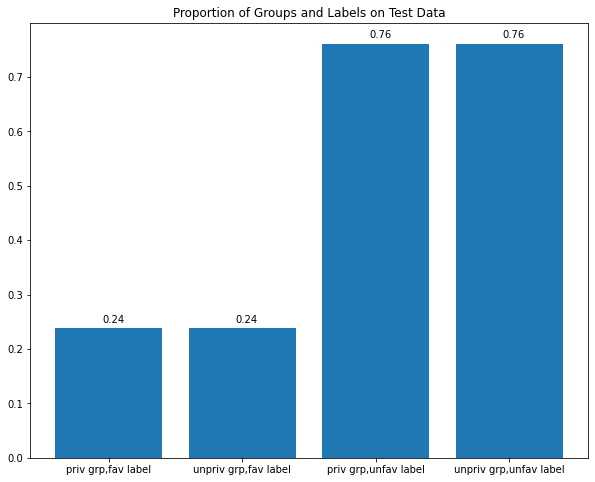

Statistical Parity Difference: -0.19082889040280115
Disparate Impact: 0.3696961802098407
Consistency: 0.7215314270115404


In [17]:
plot_prop_prtced_grp_lab(dset_raw_tst, "Proportion of Groups and Labels on Test Data")
dset_raw_tst_metrics = BinaryLabelDatasetMetric(dset_raw_tst,
                                      unprivileged_groups=unpriv_group,
                                     privileged_groups=priv_group)
print("Statistical Parity Difference:",dset_raw_tst_metrics.statistical_parity_difference())
print("Disparate Impact:",dset_raw_tst_metrics.disparate_impact())
print("Consistency:",dset_raw_tst_metrics.consistency()[0])

Looking at the Model $M$'s performance on the test set

In [18]:
M.eval()

Log_Reg(
  (linear): Linear(in_features=18, out_features=1, bias=True)
)

In [19]:
dset_tst_pred = dset_raw_tst.copy(deepcopy=True)
dset_tst = scaler.transform(dset_tst_pred.features)
dset_tst_pred.labels = (M(torch.from_numpy(dset_tst).float()) > 0.5).numpy().astype(float)

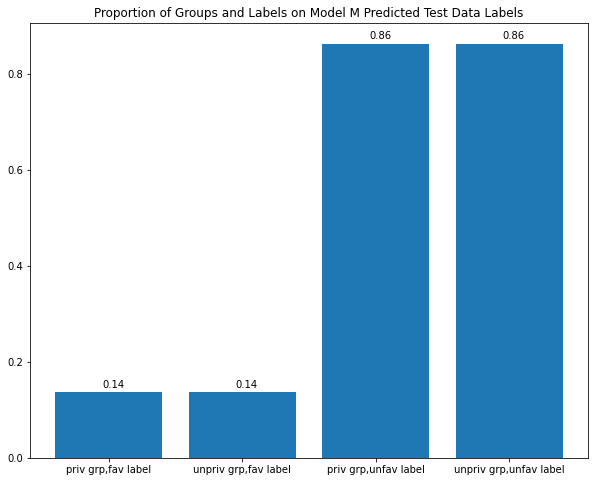

Accuracy: 0.8022930457926705
Predictive Parity Difference: -0.6511744127936032
FNR Difference: 0.44109681787406907
FPR Difference: -0.10260179332647361
Accuracy Difference: -0.12882212602850573
Statistical Parity Difference: -0.20508352977349595
Disparate Impact: 0.0
Consistency: 0.7215314270115404


In [20]:
mod_metrics = ClassificationMetric(dset_raw_tst, dset_tst_pred,
                                    unprivileged_groups=unpriv_group,
                                    privileged_groups=priv_group)
plot_prop_prtced_grp_lab(dset_tst_pred, "Proportion of Groups and Labels on Model M Predicted Test Data Labels")
print("Accuracy:", mod_metrics.accuracy())
print("Predictive Parity Difference:", mod_metrics.positive_predictive_value(False)-mod_metrics.positive_predictive_value(True))
print("FNR Difference:", mod_metrics.false_negative_rate_difference())
print("FPR Difference:", mod_metrics.false_positive_rate_difference())
print("Accuracy Difference:", mod_metrics.error_rate_difference())
print("Statistical Parity Difference:",mod_metrics.statistical_parity_difference())
print("Disparate Impact:",mod_metrics.disparate_impact())
print("Consistency:",mod_metrics.consistency()[0])

Looking at the Model $M_F$'s performance on the test set

In [21]:
M_F.eval()

Log_Reg(
  (linear): Linear(in_features=18, out_features=1, bias=True)
)

In [22]:
dset_tst_pred = dset_raw_tst.copy(deepcopy=True)
dset_tst = scaler.transform(dset_tst_pred.features)
dset_tst_pred.labels = (M_F(torch.from_numpy(dset_tst).float()) > 0.5).numpy().astype(float)

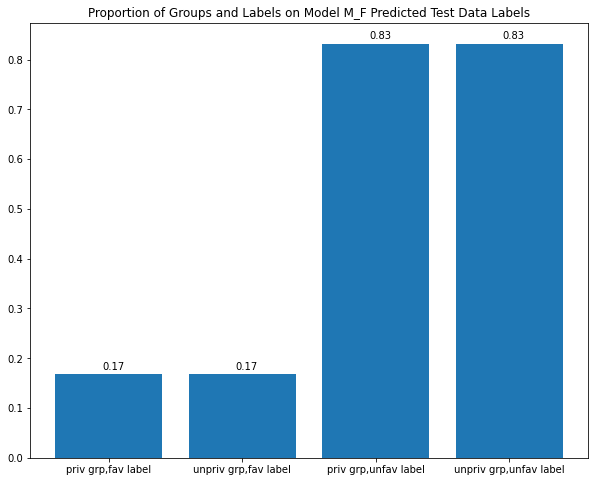

Accuracy: 0.789258172387907
Predictive Parity Difference: -0.2939555625489488
FNR Difference: 0.014850579938620934
FPR Difference: -0.005612681563588545
Accuracy Difference: -0.09747916026100911
Statistical Parity Difference: -0.06746986912697504
Disparate Impact: 0.6456924041593674
Consistency: 0.7215314270115404


In [23]:
mod_metrics = ClassificationMetric(dset_raw_tst, dset_tst_pred,
                                    unprivileged_groups=unpriv_group,
                                    privileged_groups=priv_group)
plot_prop_prtced_grp_lab(dset_tst_pred, "Proportion of Groups and Labels on Model M_F Predicted Test Data Labels")
print("Accuracy:", mod_metrics.accuracy())
print("Predictive Parity Difference:", mod_metrics.positive_predictive_value(False)-mod_metrics.positive_predictive_value(True))
print("FNR Difference:", mod_metrics.false_negative_rate_difference())
print("FPR Difference:", mod_metrics.false_positive_rate_difference())
print("Accuracy Difference:", mod_metrics.error_rate_difference())
print("Statistical Parity Difference:",mod_metrics.statistical_parity_difference())
print("Disparate Impact:",mod_metrics.disparate_impact())
print("Consistency:",mod_metrics.consistency()[0])

The performance on the testing set is pretty good in terms of fairness on the test set for $M_F$ compared to $M$. The loss in accuracy of $1.3\%$ still holds here. Hence, our equalized odd regularizer turned out pretty effective in enforcing fairness from the model trained on unfair data. Even the predictive parity and statistical parity difference is brought close to 0 and disparate impact which was 0 in case of $M$, here in case of $M_F$ even though less than $80\%$ is still better than $M$. 

In [24]:
# Saving the Models for comparison in future
torch.save(M.state_dict(), 'simple-logistic-regression.pt')
torch.save(M_F.state_dict(), 'equalized-odd-regualarized-logistic-regression.pt')

In [26]:
# Saving the Test data
with open("raw-test-data.bin", "wb") as output:
    pickle.dump(dset_raw_tst, output, pickle.HIGHEST_PROTOCOL)
# Saving the standard scaler trained on training data
with open("trained-std-scaler.bin", "wb") as output:
    pickle.dump(scaler, output, pickle.HIGHEST_PROTOCOL)